**along-track filtering exampling:**

*Goal =  produce global maps of MKE and EKE at a desired scale*

Procedure
1. load parsed_tracks*.p file for desired satellite (already placed on regular grid w/ data gaps interpolated) (data = absolute dynamic topography)
2. set time bounds to analyze and grid (how many cycles to consider for each track? * greatly affects run time of code *)
3. calculate cross-track geostrophic velocity
3. specify filter type (boxcar, taper, Gaussian) and filter scale (an integer of the along-track grid spacing equal to hor_grid_spacing)
4. create filter and filter velocites   
5. specify lat/lon grid interval and size over which to average to create global maps (at a grid smaller than 3x3 degrees, the j2 sat track gaps will become apparent)
*dependecies: altimetry_tools.py (velocity, Filter) 

*additional analysis: define filter_degrees function and filter velocites where filter length is spatially varying in km and defined as 1 degree of longitude

Output:
- a netcdf is generated of total (resolvable) KE, MKE, and EKE (where MKE and EKE are defined relative to the filter scale selected)

In [1]:
import numpy as np
import xarray as xr
import scipy.ndimage as si
import pickle 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import cartopy
import cartopy.crs as ccrs 
from datetime import datetime
from tqdm.notebook import tqdm
from altimetry_tools import velocity, Filter, smooth_tracks_deg
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# PARAMETERS TO SELECT 
this_sat = 'j2'                          # which satellite to use (at present can be j2, al, s3a)

In [3]:
# load pre-processed file for desired satellite 
# - interpolated in space and time to desired spatial resolution 
load_sat = pickle.load(open('altimeter/' + this_sat + '/' + this_sat +'_parsed_tracks_adt_x20.p', 'rb'))
load_sat2 = pickle.load(open('altimeter/' + this_sat + '/' + this_sat +'_parsed_tracks_adt_x20_interp_t.p', 'rb'))
lon_t = load_sat['lon_t']
lat_t = load_sat['lat_t']
track_t = load_sat['track_t']
adt = load_sat2['adt']  
# sla = load_sat['sla']
dist = load_sat['dist']
lon_record = load_sat['lon_record']
lat_record = load_sat['lat_record']
time_record = load_sat['time_record']
track_record = load_sat['track_record']
hor_grid_spacing = dist[1][20] - dist[1][19]
print('check on along-track grid spacing = ' + str(hor_grid_spacing) + ' km')
print('cycle count for each track = ' + str(len(time_record)))
repeat_time = (time_record[0][1] - time_record[0][0])/(60*60*24)
print('repeat time = ' + str(np.round(repeat_time,2)) + ' days')
print('mission duration = ~ ' + str(np.int(repeat_time * len(time_record))) + ' days')

check on along-track grid spacing = 20.0 km
cycle count for each track = 254
repeat time = 9.92 days
mission duration = ~ 2518 days


In [4]:
# time indices 
# - what fraction of total time series do we want to consider 
# - saves computational time 
# ******************************************
time_cutoff = len(time_record[0]) - 200 # 20   # how many cycles to consider (how long of a time series to analyze) (j2 = 129, 20 = 7yrs, 165)
# ******************************************
year_frac = ((time_record[0][0:time_cutoff] - time_record[0][0])/(60*60*24))/365
print('length of time series subsequently used = ' + str(np.round(year_frac[-1], 2)) + ' years, = ' + str(len(year_frac)) + ' values')
# - subset each track by desired time indices to speed up computation time 
subset = 1 # (yes/no)
if subset:
    sub_time_ind = range(0, time_cutoff)  # (j3=38) (s3a = 20)
    adt_t_win = []
    sla_t_win = []
    time_t_win = []
    for i in tqdm(range(len(track_record))):
        adt_t_win.append(adt[i][sub_time_ind, :])
        # -- because I principally care about ADT --> geostrophic velocity, I do not save SLA...compute it here from shorter time mean of ADT
        sla_t_win.append(adt[i][sub_time_ind, :] - np.nanmean(adt[i][sub_time_ind, :], axis=0))
        # -- if sla is saved in above file 
        # sla_t_win.append(sla[i][sub_time_ind, :])
        time_t_win.append(time_record[i][sub_time_ind])
else:
    adt_t_win = adt_time
    sla_t_win = []
    for i in range(len(track_record)):
        sla_t_win.append(adt[i] - np.nanmean(adt[i], axis=0))
    time_t_win = time_record
    
# SLA SQUARE
sla_sq = []
adt_sq = []
for i in tqdm(range(len(sla_t_win))):
    sla_sq.append(sla_t_win[i]**2)
    adt_sq.append(adt_t_win[i]**2)

length of time series subsequently used = 2.09 years, = 78 values


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

In [5]:
# --------------------------------------
# VELOCITY VELOCITY VELOCITY
# --------------------------------------
# call function, input either adt or sla
stencil_width = 3 # units of grid step (from arbic = 3,5,7)
eta_grad, total_vel, total_vel_f = velocity(dist, adt_t_win, lon_record, lat_record, track_record, stencil_width)
# VELOCITY^2 
total_vel_sq = []
for i in tqdm(range(len(total_vel))):
    total_vel_sq.append(total_vel[i]**2)
# if want to free up some memory 
# del eta_grad

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

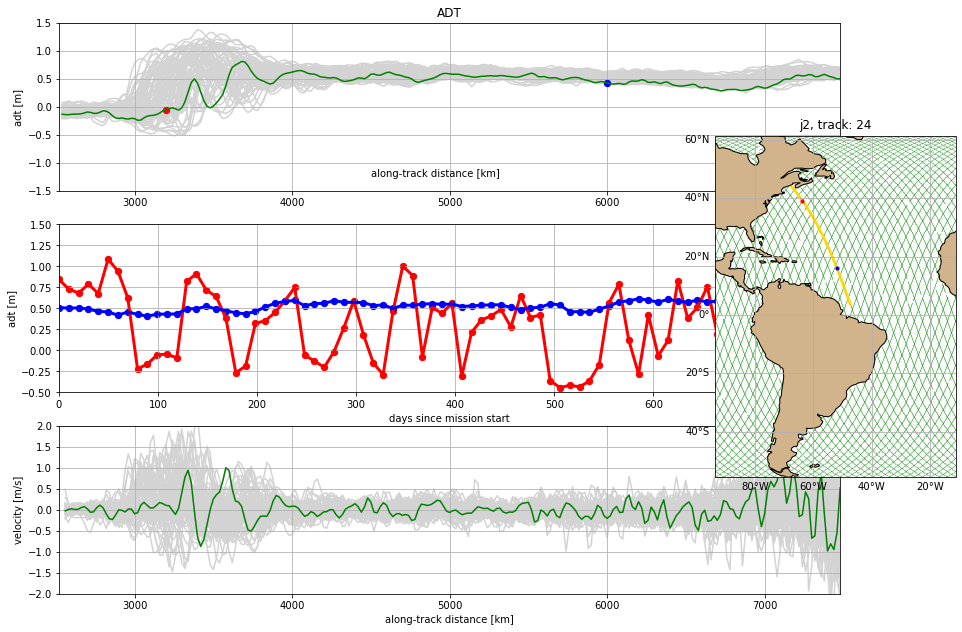

In [6]:
# CHECK 
# - sample ADT along a single track w/ temporal variability 
t_i = np.array([24])    # TRACK NO: s3a: 33 # en: 3 # J2: 24,33,124,176,200 # TP: 13,15,23 # AL: 2,549 # G2: 61,471
pass_x = 160            # along-track location to consider time series 
pass_x_2 = 300          # along-track location to consider time series
pass_t = 10             # cycle number 
xmax = 18000            # plot, horizontal axis limit 
gid = np.where(track_record == t_i)[0][0]
subset_in = np.where((dist[gid] > 2500) & (dist[gid] < 7500))[0]  # plotting subset of track 
# -- FIGURE --  
f, (ax2, ax1, ax0) = plt.subplots(3,1,figsize=(14,10.5))
# -- subplot2
ax1.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x], linewidth=3, color='r')
ax1.scatter((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x], s=40, color='r')
ax1.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x_2], linewidth=3, color='b')
ax1.scatter((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x_2], s=40, color='b')
ax1.set_ylabel('adt [m]')
ax1.set_xlabel('days since mission start')
ax1.set_ylim([-0.5, 1.5])
ax1.set_xlim([0, (time_t_win[gid][-1] - time_t_win[gid][0])/(60*60*24) + 25])
# -- inset 
a = f.add_axes([.72, .28, .35, .45], projection=ccrs.PlateCarree()) 
z_lon_w = np.nanmin(lon_record[gid])
z_lon_e = np.nanmax(lon_record[gid])
z_lat_s = np.nanmin(lat_record[gid])
z_lat_n = np.nanmax(lat_record[gid])
inn = np.where((lon_t > z_lon_w) & (lon_t < z_lon_e) & (lat_t > z_lat_s) & (lat_t < z_lat_n))[0]
# tracks that fall within this box 
[ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True) 
for i in range(len(ai)):
    a.scatter(lon_record[ai[i]], lat_record[ai[i]], s=0.01, color='g')
a.scatter(lon_record[gid][subset_in], lat_record[gid][subset_in], s=1, color='#FFD700')
a.scatter(lon_record[gid][pass_x], lat_record[gid][pass_x], s=10, color='r')
a.scatter(lon_record[gid][pass_x_2], lat_record[gid][pass_x_2], s=10, color='b')
a.set_xlim([z_lon_w, z_lon_e])
a.set_ylim([z_lat_s, z_lat_n])
a.set_xlabel('Longitude', fontsize=10, fontweight='bold')
a.set_ylabel('Latitude', fontsize=10, fontweight='bold')
a.set_title(str(this_sat) + ', track: ' + str(t_i[0]), fontsize=12, alpha=1)
# -- subplot1
for i in range(np.shape(sla_t_win[gid])[0]):
    # ax2.plot(dist[gid], sla_t_win[gid][i, :], color='#D3D3D3', zorder=1)
    ax2.plot(dist[gid], adt_t_win[gid][i, :], color='#D3D3D3', zorder=1)
ax2.plot(dist[gid], adt_t_win[gid][pass_t, :], color='g', zorder=2)
# ax2.plot(dist[gid], sla_t_win[gid][pass_t, :], color='g', zorder=2)
ax2.scatter(dist[gid][pass_x], adt_t_win[gid][pass_t, pass_x], color='r', s=40, zorder=2)
ax2.scatter(dist[gid][pass_x_2], adt_t_win[gid][pass_t, pass_x_2], color='b', s=40, zorder=2)
ax2.set_title('ADT')
ax2.set_ylabel('adt [m]')
ax2.text(np.nanmean(dist[gid][subset_in])-500, -1.25, 'along-track distance [km]')
ax2.set_ylim([-1.5, 1.5])
ax2.set_xlim([np.nanmin(dist[gid][subset_in]), np.nanmax(dist[gid][subset_in])])

# -- subplot3
for i in range(np.shape(total_vel[gid])[0]):
    ax0.plot(dist[gid], total_vel[gid][i, :], color='#D3D3D3', zorder=1)
ax0.plot(dist[gid], total_vel[gid][pass_t, :], color='g', zorder=2)
ax0.set_xlim([np.nanmin(dist[gid][subset_in]), np.nanmax(dist[gid][subset_in])])
ax0.set_ylim([-2, 2])
ax0.set_ylabel('velocity [m/s]')
ax0.set_xlabel('along-track distance [km]')

# -- formatting 
a.add_feature(cartopy.feature.LAND, color='#D2B48C')
a.coastlines()
a.set_extent([z_lon_w, z_lon_e, z_lat_s, z_lat_n], crs=ccrs.PlateCarree())
gl = a.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
ax2.grid()
ax1.grid()
ax0.grid()
plt.show()
# f.savefig(this_sat + '_sample_adt_space_time', dpi=250)

Using default N, N = 32 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 32 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 10 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 10 If d>2 or X is not pi then results might not be accurate.


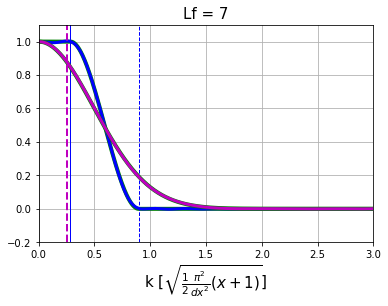

In [7]:
# VELOCITY FILTERING EXAMPLE 
# construct filter 
sample_LfB = 7                             # boxcar (full width of filter) 
sample_LfT = sample_LfB                    # sharp
sample_LfG = sample_LfB                    # gaussian 
plot_filter = 1 
vel_taper = Filter('Taper', total_vel, 1, sample_LfT, plot_filter=1)
vel_sq_taper = Filter('Taper', total_vel_sq, 1, sample_LfT)
vel_gauss = Filter('Gaussian', total_vel, 1, sample_LfG, plot_filter=1)
vel_sq_gauss = Filter('Gaussian', total_vel_sq, 1, sample_LfG)
vel_boxcar = Filter('boxcar', total_vel, 1, sample_LfB)
vel_sq_boxcar = Filter('boxcar', total_vel_sq, 1, sample_LfB)

In [35]:
# filter velocity using a Gaussian filter to an effective model resolution (IN DEGREES)
def filter_degrees(total_vel, lon_record, lat_record, dist, resolution, sigma):
    vel_1deg = []
    for m in tqdm(range(len(total_vel))):
        this_track = total_vel[m]
        this_lon = lon_record[m]
        this_lat = lat_record[m]
        this_dist = dist[m]     
        this_lon_step = 1852 * 60 * np.cos(np.deg2rad(this_lat)) * (resolution)
        track_filt = np.nan * np.ones(np.shape(this_track))
        for i in range(11, np.shape(this_track)[1] - 11):  # loop across all space
            if np.isnan(this_lon_step[i]):
                continue
            # create local grid 
            this_local_grid = np.arange(-this_lon_step[i]*4, this_lon_step[i]*5, this_lon_step[i])   
            # loop in time (across each cycle)
            for k in range(np.shape(this_track)[0]):                                                   
                track_on_local_lon_grid = np.interp(this_local_grid, (this_dist[i-10:i+11]*1000) - this_dist[i]*1000, \
                                                    this_track[k, i-10:i+11])
                # filter
                track_filt0 = si.gaussian_filter(track_on_local_lon_grid, sigma/resolution, order=0)
                # extract middle index 
                if np.mod(len(track_on_local_lon_grid)/2,1) > 0:
                    track_filt[k,i] = np.interp(np.median(this_local_grid), this_local_grid, track_filt0)
                else:
                    mid_i = np.int(len(track_on_local_lon_grid)/2)
                    track_filt[k, i] = track_filt0[mid_i]     
        vel_1deg.append(track_filt)
    return vel_1deg 

In [36]:
resolution = 0.2 # place each track on a lat/lon grid (this value specifies that grid resolution)
sigma = 1        # gaussian filter scale [degrees] (will be converted to indices when called) 
vel_1deg = filter_degrees(total_vel, lon_record, lat_record, dist, resolution, sigma)
vel_sq_1deg = filter_degrees(total_vel_sq, lon_record, lat_record, dist, resolution, sigma)

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

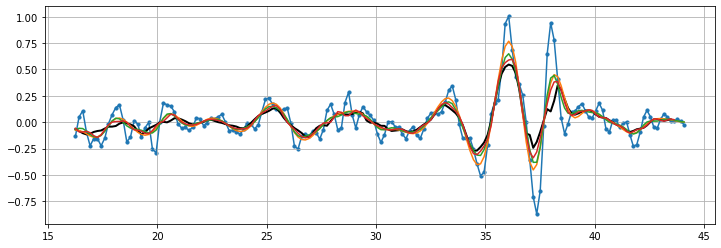

In [37]:
m = gid    # track index 
k = 10     # cycle index 
pdist = np.arange(100,300)  # track distance indices to consider 
this_dist = lat_record[m]   # plot as a function of latitude (can also choose dist, lon_record)
this_track = total_vel[m]
f, ax = plt.subplots(1,1,figsize=(14,4))
ax.plot(this_dist[pdist], this_track[k, pdist])
ax.scatter(this_dist[pdist], this_track[k, pdist],s=10)
ax.plot(this_dist[pdist], vel_1deg[m][k, pdist],color='k',linewidth=2)
ax.plot(this_dist[pdist], vel_taper[m][k, pdist])
ax.plot(this_dist[pdist], vel_gauss[m][k, pdist])
ax.plot(this_dist[pdist], vel_boxcar[m][k, pdist])
# ax.plot(this_local_grid, si.gaussian_filter(sla_on_local_lon_grid, sigma, order=0))
ax.grid()

In [ ]:
# 2D climatology 

In [38]:
# lat/lon bounds within which to map 
lon_w = 0
lon_e = 360
lat_s = -70
lat_n = 70
step = 1                                                    # lat/lon grid step (map resolution)
# window over which to average in creating maps 
lon_win = 3                                                 # lat bin width
lat_win = 3                                                 # lon bin width 
lon_bins = np.arange(lon_w, lon_e + step, step) 
lat_bins = np.arange(lat_s, lat_n + step, step)
lon_bin_c = lon_bins[0:-1] + np.diff(lon_bins)/2             # lon bin centers 
lat_bin_c = lat_bins[0:-1] + np.diff(lat_bins)/2             # lat bin centers 
thresh = 25*len(time_t_win[0])/12                            # minimum number of data point locations in each lat/lon bin average 

# *** matching list ***
# lon_t, lat_t, track_t are keys to cross-reference tracks when average within lat/lon boxes 
# these are loaded in initial file 

In [39]:
# prep for partitioning into months 
year_day = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # days per month 
year_time_record = []
for i in range(len(time_t_win)):
    t_s = datetime.utcfromtimestamp(time_t_win[i][0])  # start time 
    offset_i = np.sum(year_day[0:t_s.month - 1])/365 + t_s.day/365 + t_s.hour/(365*24)  # starting time index (fractional days)
    year_time_record.append(((time_t_win[i] - time_t_win[i][0])/(60*60*24))/365 + offset_i)

In [40]:
# variable to generate 2d map 
field_raw = total_vel                             # unfilted field 
field_filtered = [vel_taper]                      # list where each element is the field filtered to a desired scale 
field_filtered2 = [vel_gauss]                     # list2 where each element is the field filtered to a desired scale 
field_filtered3 = [vel_1deg]                      # list3 where each element is the field filtered to a desired scale 
coarsening_factors = np.array([sample_LfB])       # for most cases we just want to produce a map a 1 filter scale 

In [41]:
# ---> ALONG-TRACK ---> 2d MAP (variance at each scale as a function of time) 
# twelve increments (months)
months = np.concatenate((np.array([0]), (np.cumsum(np.array([year_day])))))/365
s_i = np.concatenate((months[0:-1][:, None], months[1:][:, None]), axis=1) 
# --- initialize arrays --- 
mean_field_raw = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
# mean_sla_Ld = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_field_filtered = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_field_filtered2 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_field_filtered3 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_field_eke = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_field_eke2 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_field_eke3 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
# --- MASTER LOOPS ---  
for tt in range(len(s_i)):                         # month 
    for i in tqdm(range(1, len(lon_bin_c) - 1)):   # lon
        for j in range(1, len(lat_bin_c) - 1):     # lat      
            this_lon = lon_bin_c[i]
            this_lat = lat_bin_c[j]     
            this_lon0 = this_lon - lon_win/2
            this_lon1 = this_lon + lon_win/2
            this_lat0 = this_lat - lat_win/2
            this_lat1 = this_lat + lat_win/2      
            inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
            # tracks that fall within this box 
            [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
            countf = 0
            filters = {}
            filtersG = {}
            filtersB = {}
            filtersDeg = {}
            for tib in range(len(ai)):
                # for each track that crosses through box, again find subset of grid points in box 
                inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & \
                                (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1) & \
                                (np.abs(lat_record[ai[tib]]) > 5))[0]
                # time bin 
                this_time = np.mod(year_time_record[ai[tib]], 1)
                time_in = np.where((this_time > s_i[tt, 0]) & (this_time < s_i[tt, 1]))[0]
                
                # loop over each filter scale (ORDER large to small)   
                if countf < 1:
                    sla_i = field_raw[ai[tib]][time_in][:, inn2].flatten()                         # raw
                    # sla_Ld_i = sla_Ld_dict[ai[tib]][time_in][:, inn2].flatten()
                    for ff in range(len(coarsening_factors)):  
                        filters[coarsening_factors[ff]] = field_filtered[ff][ai[tib]][time_in][:, inn2].flatten()
                        filtersG[coarsening_factors[ff]] = field_filtered2[ff][ai[tib]][time_in][:, inn2].flatten()
                        # filtersB[coarsening_factors[ff]] = vel_b_dict[ff][ai[tib]][time_in][:, inn2].flatten()
                        filtersDeg[coarsening_factors[ff]] = field_filtered3[ff][ai[tib]][time_in][:, inn2].flatten()
                    countf = countf + 1
                else:
                    sla_i = np.append(sla_i, field_raw[ai[tib]][time_in][:, inn2].flatten())
                    # sla_Ld_i = np.append(sla_Ld_i, sla_Ld_dict[ai[tib]][time_in][:, inn2].flatten())
                    for ff in range(len(coarsening_factors)):  # range(len(coarsening_factors)-1, -1, -1):
                        filters[coarsening_factors[ff]] = np.concatenate((filters[coarsening_factors[ff]], field_filtered[ff][ai[tib]][time_in][:, inn2].flatten()))
                        filtersG[coarsening_factors[ff]] = np.concatenate((filtersG[coarsening_factors[ff]], field_filtered2[ff][ai[tib]][time_in][:, inn2].flatten()))
                        # filtersB[coarsening_factors[ff]] = np.concatenate((filtersB[coarsening_factors[ff]], vel_b_dict[ff][ai[tib]][time_in][:, inn2].flatten()))
                        filtersDeg[coarsening_factors[ff]] = np.concatenate((filtersDeg[coarsening_factors[ff]], field_filtered3[ff][ai[tib]][time_in][:, inn2].flatten()))
            
            # average in each lat/lon box 
            if countf > 0:  # (len(ai) > 1):
                if (len(sla_i) > thresh):
                    # -- unfiltered eddy energy estimate (highest resolution)
                    mean_field_raw[tt, i, j] = np.nanmean(sla_i**2)  
                    # mean_sla_Ld[tt,i,j] = np.nanmean(sla_Ld_i**2)
                    # mean_diff0Ld[tt,i,j] = np.nanmean(sla_i**2 - sla_Ld_i**2)              
                    # ORDER = large to small 
                    for cf in range(len(coarsening_factors)):
                        # -- large scale (\overline{\eta}^2) (filtering of the quantity, then squaring)
                        mean_field_filtered[tt,i,j,cf] = np.nanmean(filters[coarsening_factors[cf]]**2)
                        mean_field_filtered2[tt,i,j,cf] = np.nanmean(filtersG[coarsening_factors[cf]]**2)
                        mean_field_filtered3[tt,i,j,cf] = np.nanmean(filtersDeg[coarsening_factors[cf]]**2)
                        # mean_sla_smoothB[tt,i,j,cf] = np.nanmean(filtersB[coarsening_factors[cf]]**2)
                        # - SHARP -- EKE w/o filtering the squared velocity 
                        mean_field_eke[tt,i,j,cf] = np.nanmean(sla_i**2 - filters[coarsening_factors[cf]]**2) 
                        mean_field_eke2[tt,i,j,cf] = np.nanmean(sla_i**2 - filtersG[coarsening_factors[cf]]**2)
                        mean_field_eke3[tt,i,j,cf] = np.nanmean(sla_i**2 - filtersDeg[coarsening_factors[cf]]**2)
                    
            ai = 0

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

In [43]:
# create xarray object with
mo_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data_coords = {'month': mo_list, 'latitude': lat_bin_c, 'longitude': lon_bin_c}
time_start = str(datetime.utcfromtimestamp(time_record[0][0]))[0:10]
time_end = str(datetime.utcfromtimestamp(time_record[0][-1]))[0:10]

# wrap all variables into a dataset 
map_xr = xr.Dataset({'TKE': (['month', 'latitude', 'longitude'], np.transpose(mean_field_raw, axes=(0,2,1))), \
                      'MKE_taper': (['month', 'latitude', 'longitude'], np.transpose(mean_field_filtered[:, :, :, 0], axes=(0,2,1))), \
                      'MKE_gaussian': (['month', 'latitude', 'longitude'], np.transpose(mean_field_filtered2[:, :, :, 0], axes=(0,2,1))), \
                      'MKE_1Deg': (['month', 'latitude', 'longitude'], np.transpose(mean_field_filtered3[:, :, :, 0], axes=(0,2,1))), \
                      'EKE_taper': (['month', 'latitude', 'longitude'], np.transpose(mean_field_eke[:, :, :, 0], axes=(0,2,1))), \
                      'EKE_1Deg': (['month', 'latitude', 'longitude'], np.transpose(mean_field_eke[:, :, :, 0], axes=(0,2,1)))}, \
                    coords = {'month': mo_list, 'latitude': lat_bin_c, 'longitude': lon_bin_c})
map_xr.attrs = {'satellite': this_sat, 'time start': time_start, 'time end': time_end, 'unit': 'm^2s^2', 'grid scale': hor_grid_spacing, \
                'filter scale l [km]': sample_LfB*hor_grid_spacing, 'filter factor': sample_LfB, 'lat_lon bin [degree]': lon_win, \
                'filter type': 'taper'}

mean_field_raw_xr = xr.DataArray(data=np.transpose(mean_field_raw, axes=(0,2,1)), \
                                 name=this_sat + ': total kinetic energy', dims=['month', 'latitude', 'longitude'], coords=data_coords)
mean_field_filtered_xr = xr.DataArray(data=np.transpose(mean_field_filtered[:, :, :, 0], axes=(0,2,1)), \
                                      name='MKE taper', dims=['month', 'latitude', 'longitude'], coords=data_coords)
mean_field_filtered2_xr = xr.DataArray(data=np.transpose(mean_field_filtered2[:, :, :, 0], axes=(0,2,1)), \
                                      name='MKE Gaussian', dims=['month', 'latitude', 'longitude'], coords=data_coords)
mean_field_filtered3_xr = xr.DataArray(data=np.transpose(mean_field_filtered3[:, :, :, 0], axes=(0,2,1)), \
                                      name='MKE 1Deg', dims=['month', 'latitude', 'longitude'], coords=data_coords)
mean_field_eke_xr = xr.DataArray(data=np.transpose(mean_field_eke[:, :, :, 0], axes=(0,2,1)), \
                                      name='EKE Taper', dims=['month', 'latitude', 'longitude'], coords=data_coords)
mean_field_eke_1Deg_xr = xr.DataArray(data=np.transpose(mean_field_eke3[:, :, :, 0], axes=(0,2,1)), \
                                      name='EKE 1Deg', dims=['month', 'latitude', 'longitude'], coords=data_coords)

In [44]:
# export 
map_xr.to_netcdf(this_sat + '_global_ke_mke_eke_140_w1Deg.nc', 'w')

In [ ]:
# May choose to run all cells below this by loading file rather than running all cells above this 


In [45]:
mean_taper_gauss_diff = mean_field_filtered_xr - mean_field_filtered2_xr

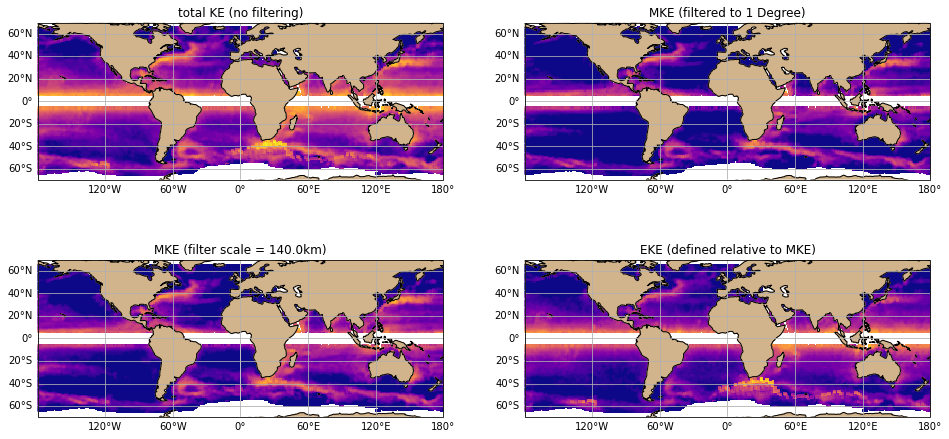

In [49]:
# total results figure (KE, MKE, EKE )
lon_in = np.where((lon_bin_c > 0) & (lon_bin_c < 360))[0]
lat_in = np.where((lat_bin_c > -80) & (lat_bin_c < 80))[0]

fig, axs = plt.subplots(2,2,figsize=(16,8),subplot_kw={'projection':ccrs.PlateCarree()})
mean_field_raw_xr.mean(dim='month').isel(longitude=lon_in, latitude=lat_in).plot(ax=axs[0,0],transform=ccrs.PlateCarree(), \
                                                                       norm=LogNorm(vmin=0.005, vmax=1), \
                                                                       cmap=plt.get_cmap('plasma'), zorder=0, add_colorbar=False)
mean_field_raw_xr.attrs = {'source': this_sat}
mean_field_filtered_xr.mean(dim='month').isel(longitude=lon_in, latitude=lat_in).plot(ax=axs[1,0],transform=ccrs.PlateCarree(), \
                                                                       norm=LogNorm(vmin=0.005, vmax=1), \
                                                                       cmap=plt.get_cmap('plasma'), zorder=0, add_colorbar=False)
mean_field_eke_xr.mean(dim='month').isel(longitude=lon_in, latitude=lat_in).plot(ax=axs[1,1],transform=ccrs.PlateCarree(), \
                                                                       norm=LogNorm(vmin=0.005, vmax=1), \
                                                                       cmap=plt.get_cmap('plasma'), zorder=0, add_colorbar=False)
mean_field_filtered3_xr.mean(dim='month').isel(longitude=lon_in, latitude=lat_in).plot(ax=axs[0,1],transform=ccrs.PlateCarree(), \
                                                                       norm=LogNorm(vmin=0.005, vmax=1), \
                                                                       cmap=plt.get_cmap('plasma'), zorder=0, add_colorbar=False)

axs[0,0].set_title('total KE (no filtering)')
axs[1,0].set_title('MKE (filter scale = ' + str(sample_LfT*hor_grid_spacing) + 'km)')
axs[1,1].set_title('EKE (defined relative to MKE)')
axs[0,1].set_title('MKE (filtered to 1 Degree)')
for ax in axs.flatten():
    ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    ax.coastlines()
    ax.set_extent([np.nanmin(lon_bin_c[lon_in]), np.nanmax(lon_bin_c[lon_in]), \
                np.nanmin(lat_bin_c[lat_in]), np.nanmax(lat_bin_c[lat_in])], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
plt.show()

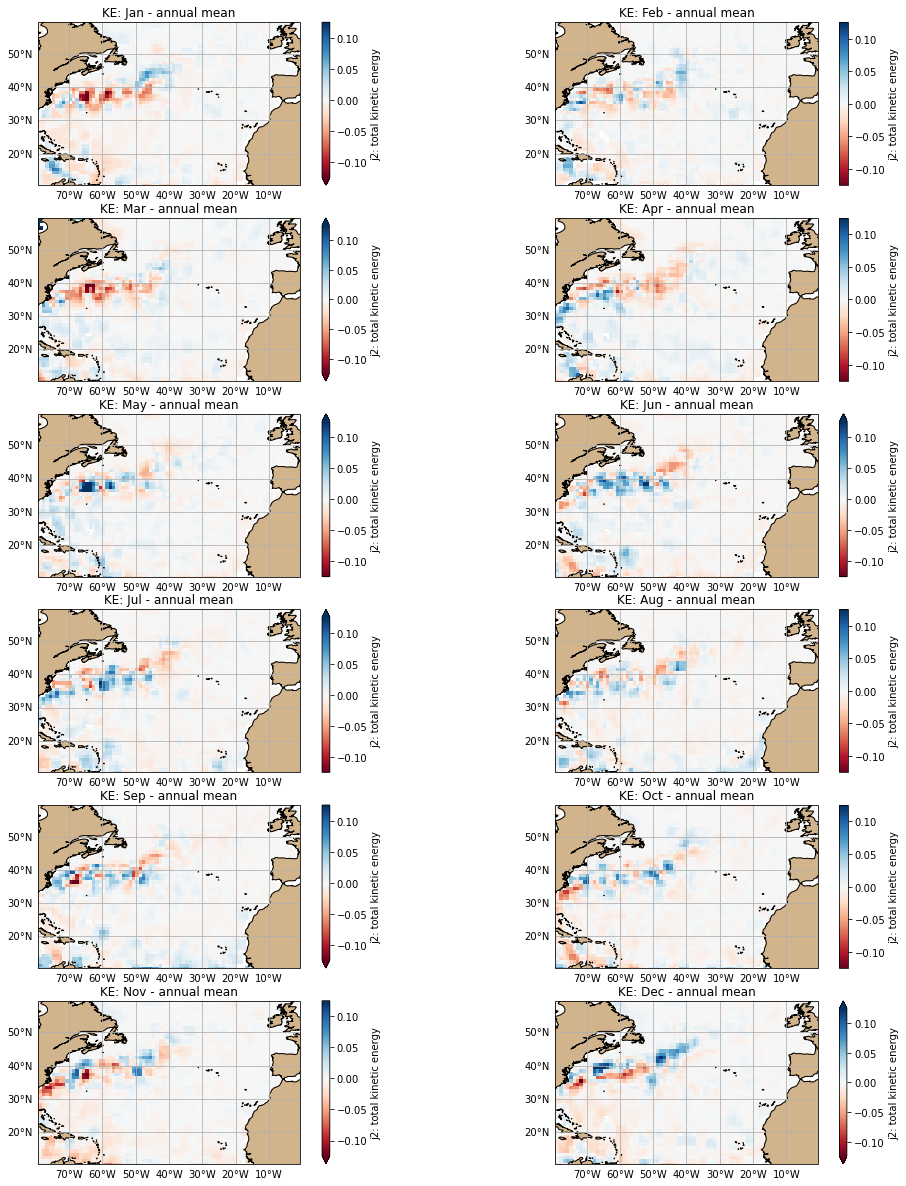

In [56]:
# climatology (for unfiltered KE)
# monthly anomalies relative to annual mean 
lon_in = np.where((lon_bin_c > 280) & (lon_bin_c < 360))[0]
lat_in = np.where(((lat_bin_c > 10) & (lat_bin_c < 60)))[0]
fig, axs = plt.subplots(6,2,figsize=(17,21),subplot_kw={'projection':ccrs.PlateCarree()})
i = 0
for ax in axs.flatten():
    monthly_anomaly = mean_field_raw_xr.isel(month=i, longitude=lon_in, latitude=lat_in) - \
        mean_field_raw_xr.mean(dim='month').isel(longitude=lon_in, latitude=lat_in)
    monthly_anomaly.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-0.125, vmax=0.125, \
                         cmap=plt.get_cmap('RdBu'), zorder=0, add_colorbar=True)
    ax.set_title('KE: ' + mo_list[i] + ' - annual mean')
    ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    ax.coastlines()
    ax.set_extent([np.nanmin(lon_bin_c[lon_in]), np.nanmax(lon_bin_c[lon_in]), \
                np.nanmin(lat_bin_c[lat_in]), np.nanmax(lat_bin_c[lat_in])], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    i = i + 1
plt.show()
# fig.savefig(this_sat + '_sample_climatology', dpi=450)

In [ ]:
# note for j2, seasonality is strongly apparent in the agulhas 
# 'seasonal variability in the agulhas retroflection region, matano et al. 1998'

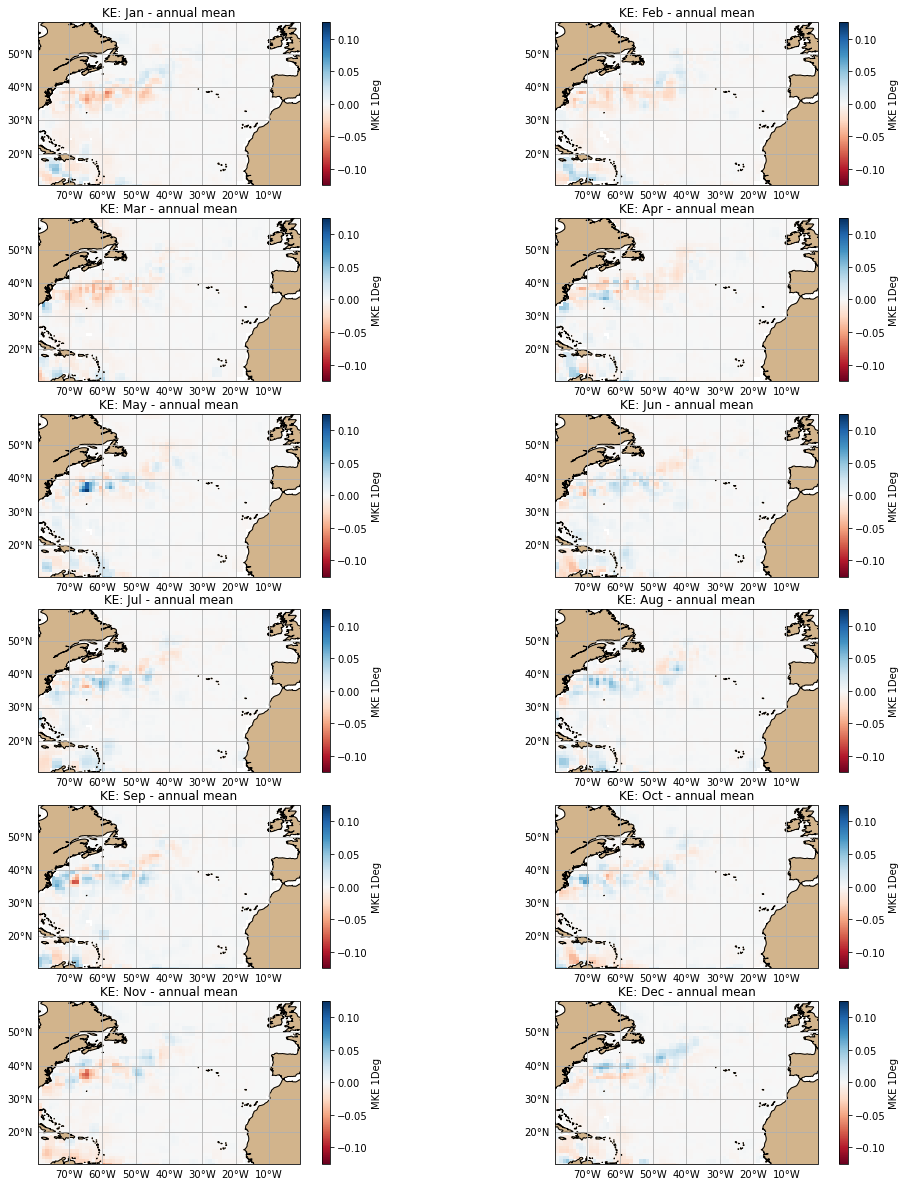

In [57]:
# climatology (for 1Deg)
# monthly anomalies relative to annual mean 
lon_in = np.where((lon_bin_c > 280) & (lon_bin_c < 360))[0]
lat_in = np.where(((lat_bin_c > 10) & (lat_bin_c < 60)))[0]
fig, axs = plt.subplots(6,2,figsize=(17,21),subplot_kw={'projection':ccrs.PlateCarree()})
i = 0
for ax in axs.flatten():
    # Monthly anomaly of MKE (filtered to 1Deg)
    monthly_anomaly = (mean_field_filtered3_xr.isel(month=i, longitude=lon_in, latitude=lat_in) - \
        mean_field_filtered3_xr.mean(dim='month').isel(longitude=lon_in, latitude=lat_in))
    monthly_anomaly.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-0.125, vmax=0.125, \
                         cmap=plt.get_cmap('RdBu'), zorder=0, add_colorbar=True)
    ax.set_title('KE: ' + mo_list[i] + ' - annual mean')
    ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    ax.coastlines()
    ax.set_extent([np.nanmin(lon_bin_c[lon_in]), np.nanmax(lon_bin_c[lon_in]), \
                np.nanmin(lat_bin_c[lat_in]), np.nanmax(lat_bin_c[lat_in])], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    i = i + 1
plt.show()
# fig.savefig(this_sat + '_sample_climatology', dpi=450)